In [1]:
# Start loading libraries

#! pip install yfinance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#! pip install pmdarima
import pmdarima as pm 
from pmdarima import model_selection
from pmdarima.model_selection import SlidingWindowForecastCV

import scipy
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from arch.unitroot import KPSS

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

#from matplotlib.ticker import NullFormatter
#import yfinance as yf
#import warnings; warnings.simplefilter('ignore')
#%matplotlib inline

In [2]:
xls_file = pd.ExcelFile("Data_monthly_final.xlsx") # Read Excel
df1=xls_file.parse("WTI") # Read the first sheet (Portfolio holdings)

#df1["Timestamp"] = df1["Date"].astype('datetime64[ns]') # Convert column to date format
df1 = df1.set_index(['Timestamp']) # use first column as index

#df1.to_excel("values.xlsx")  #print to excel



In [3]:
spot = df1["CLc1"]
spot = np.log(spot)
spot = spot.loc['2004-01-31':'2022-11-30']
spot_train = spot.loc[:'2016-07-31']
#spot_train.plot()

In [4]:
# Load the data and split it into separate pieces
data = np.array(spot.dropna())
train, test = model_selection.train_test_split(data, train_size=(spot_train.shape[0]))
#train, test = model_selection.train_test_split(data, train_size=(spot.shape[0]-1))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-279.221, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-276.896, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-283.701, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-281.433, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-278.857, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-285.697, Time=0.03 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-283.702, Time=0.10 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-281.702, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=-284.746, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-284.255, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-283.397, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-284.754, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-287.678, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-285.683, Time=0.04 sec
 ARIMA(1,1,0)(0,0,1

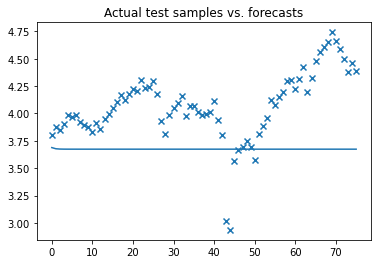

In [5]:
# Fit a simple auto_arima model
autoarima = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True,
                      seasonal=True, m=12)

#arima = pm.auto_arima(train, error_action='ignore', trace=True,
                      #suppress_warnings=True, maxiter=5,
                      #seasonal=True, m=12)

# #############################################################################
# Plot actual test vs. forecasts:
x = np.arange(test.shape[0])
plt.scatter(x, test, marker='x')
plt.plot(x, autoarima.predict(n_periods=test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()

In [6]:
autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  151
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 145.839
Date:                Sun, 06 Aug 2023   AIC                           -287.678
Time:                        12:18:31   BIC                           -281.657
Sample:                             0   HQIC                          -285.232
                                - 151                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2661      0.078      3.424      0.001       0.114       0.418
sigma2         0.0084      0.001     10.054      0.000       0.007       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 7.87
Prob(Q):                              0.78   Prob(JB):                         0.02
Heteroskedasticity (H):               1.01   Skew:                            -0.29
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
### The same with non-automatic ARIMA from pmdarima ####

ar = pm.ARIMA(order=(0,1,0), with_intercept=False)
ar.fit(spot_train)
ar.summary()

c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  151
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 140.428
Date:                Sun, 06 Aug 2023   AIC                           -278.857
Time:                        12:18:31   BIC                           -275.846
Sample:                    01-31-2004   HQIC                          -277.634
                         - 07-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0090      0.001     11.343      0.000       0.007       0.011
===================================================================================
Ljung-Box (L1) (Q):                  10.46   Jarque-Bera (JB):                22.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.60
Prob(H) (two-sided):                  0.45   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
def smape_kun(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true))/2))*100

In [9]:
### with pmdarima sliding window ####

cv = SlidingWindowForecastCV(window_size=151)
predictions = model_selection.cross_val_predict(
    ar, spot, cv=cv, verbose=0)


c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M w

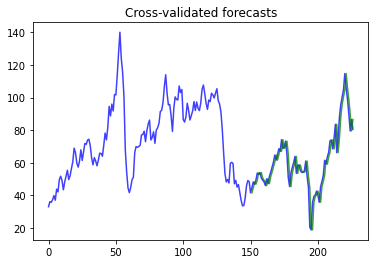

In [10]:
exp_predictions = np.exp(predictions)
exp_spot= np.exp(spot)
exp_test = np.exp(test)
exp_train = np.exp(train)

x_axis = np.arange(exp_spot.shape[0])
n_test = exp_predictions.shape[0]

plt.plot(x_axis, exp_spot, alpha=0.75, c='b')
plt.plot(x_axis[-n_test:], exp_predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Cross-validated forecasts")
plt.show()

In [11]:
error = mean_squared_error(exp_test, exp_predictions)
print('Mean Squared Error: %.3f' % error)
error2 = mean_absolute_error(exp_test, exp_predictions)
print('Mean Absolute Error: %.3f' % error2)
error3 = mean_absolute_percentage_error(exp_test, exp_predictions)
print('Mean Absolute Percentage Error: %.3f' % (error3*100))
error4 = smape_kun(exp_test, exp_predictions)
print('Symmetric Mean Absolute Percentage Error: %.3f' % error4)

Mean Squared Error: 46.132
Mean Absolute Error: 5.285
Mean Absolute Percentage Error: 9.842
Symmetric Mean Absolute Percentage Error: 9.431


In [12]:
### same with built-in function ###

#predictions22 = model_selection.cross_val_score(
#    ar, spot, scoring='mean_absolute_error', cv=cv, verbose=0)
#np.average(predictions22)

In [13]:
#### MASE ###

abs_errors = abs(exp_predictions - exp_test)
mae_naive_list = []

for x in range(len(exp_test)):
    insample_data = exp_spot[x:-(len(exp_test)-x)]
    mae_insample = np.mean(abs(insample_data.diff().dropna()))
    mae_naive_list.append(mae_insample)

mase = np.mean(abs_errors / mae_naive_list)

print('Mean Absolute Scaled Error: %.3f' % mase)

Mean Absolute Scaled Error: 1.024


In [14]:
### Returns ###

returns = []

test_app2 = list(exp_test)
test_app2.insert(0, exp_train[-1]) ## append last of train data
price_moves = np.array(pd.DataFrame(test_app2).pct_change().dropna()+1)

pred_app2 = list(predictions)

test_shift2 = list(test)
test_shift2.insert(0, train[-1])
test_shift2.pop()

dir_pred2 = np.array(np.sign([a - b for a, b in zip(pred_app2,test_shift2)]))

for t in range(len(dir_pred2)):
    if dir_pred2[t] == 1:
            returns.append(price_moves[t])
        
    if dir_pred2[t] == -1:
        returns.append(1/price_moves[t])

returns = pd.DataFrame(returns)
returns


,0
0,1.052448
1,1.121559
2,1.092897
3,1.002034


In [15]:
### Returns t-test ###

t_statistic, p_value = stats.ttest_1samp(a=returns, popmean=1, alternative='greater') ### one tailed test?


print(t_statistic , p_value)

[2.59115914] [0.04049638]


In [16]:
### Merton test ###

test_app = list(test)
test_app.insert(0, train[-1]) ## append last of train data
dir = np.array(np.sign(pd.DataFrame(test_app).diff().dropna()))

pred_app = list(predictions)

test_shift = list(test)
test_shift.insert(0, train[-1])
test_shift.pop()

dir_pred = np.array(np.sign([a - b for a, b in zip(pred_app,test_shift)]))

q_minus = 0
q_plus = 0
pred_minus = 0
pred_plus = 0

for t in range(len(dir)):
    if dir[t] == 1:
        q_plus += 1
        if dir_pred[t] == 1:
            pred_plus += 1
    if dir[t] == -1:
        q_minus += 1
        if dir_pred[t] == -1:
            pred_minus += 1

print('Merton test: %.3f' % ((pred_plus / q_plus) + (pred_minus / q_minus)))

Merton test: 0.099


<AxesSubplot:xlabel='Timestamp'>

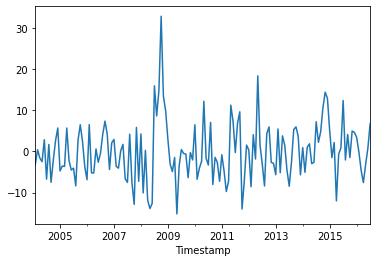

In [17]:
### Residuals diagnostics ###

fitted = np.exp(ar.fittedvalues())

resid = fitted - exp_train
resid =resid.iloc[1:]
resid.to_excel("arimaresiduals3.xlsx", header=['WTI1'])
resid.plot()